## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw

### Dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations

Position is sensed, perturbed by Gaussian noise:

$$y_k = C z_k + r_k$$

where $r_k$ is measurement noise with covariance matrix $R$. 

### Probabilistic model

The above system can be captured with a probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid C z_k, R) \, .
\end{align}$$

## Experiments

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

using Revise
using Colors
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using StatsPlots
using Plots
default(label="", grid=false, markersize=3, margin=15Plots.pt)

includet("../Robots.jl"); using. Robots
includet("../MARXAgents.jl"); using. MARXAgents
includet("../util.jl");

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks`


In [14]:
# Time
Δt = 0.2
len_trial = 20
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 3;

# Dimensionalities
Mu = 2
My = 2
Dy = 2
Du = Dy
Dx = My*Dy + Mu*Du

# Setpoint (desired observation)
z_star = [0.0, 1., 0.0, 0.0]
goal = MvNormal(z_star[1:2], 0.5diagm(ones(2)))

# Parameters
σ = [1e-3, 1e-3]
ρ = [1e-3, 1e-3]
η = 0.0

# Limits of controller
u_lims = (-1.0, 1.0)
opts = Optim.Options(time_limit=20)

# Initial state
z_0 = [0.0, -1., 0., 0.]

# Initial belief
m_0 = z_0
S_0 = 0.1diagm(ones(4));

# Start robot
fbot  = FieldBot(ρ,σ, Δt=Δt, control_lims=u_lims)

# Start agent
ν0 = 2
V0 = diagm(ones(Dy))
U0 = diagm(ones(Dx))
M0 = 1e-8*randn(Dx,Dy)
agent = MARXAgent(M0,U0,V0,ν0, goal, Dy=Dy, Du=Du, delay_inp=Mu, delay_out=My)

MARXAgent(2, 8, 2, [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], 2, 2, [-1.0308218606928035e-8 -3.6030326861177613e-9; -1.517742558282002e-8 1.993160524808982e-10; … ; -1.727167084800793e-8 1.4516136199356445e-8; -5.94365727578362e-9 2.665992654872309e-9], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0; 0.0 1.0], 2.0, 0.0, FullNormal(
dim: 2
μ: [0.0, 1.0]
Σ: [0.5 0.0; 0.0 0.5]
)
, 1, 10, Inf)

### System identification

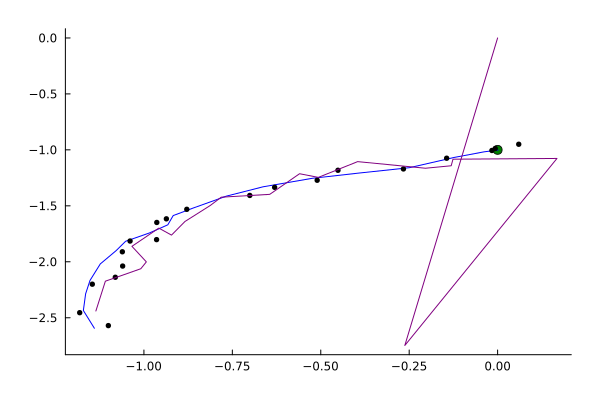

In [20]:
# Preallocate
z_sim  = zeros(4,len_trial)
y_sim  = zeros(2,len_trial)
u_sim  = zeros(2,len_trial)
preds_m  = zeros(2,len_trial)
preds_S  = zeros(2,2,len_trial)

# Fix controls
u_sim = randn(2,len_trial)

# Fix starting state
z_sim[:,1] = z_0
y_sim[:,1] = emit(fbot, z_sim[:,1])

for k in 2:len_trial

    # Predictions
    x_k = [agent.ubuffer[:]; agent.ybuffer[:]]
    preds_m[:,k] = agent.M'*x_k

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])

    # Update parameters
    MARXAgents.update!(agent, y_sim[:,k], u_sim[:,k])
end

scatter([z_0[1]], [z_0[2]], color="green", markersize=5)
plot!(z_sim[1,:], z_sim[2,:], color="blue")
scatter!(y_sim[1,:], y_sim[2,:], color="black")
plot!(preds_m[1,:], preds_m[2,:], color="purple")

### Control

In [17]:
# Preallocate
z_est  = (zeros(4,len_trial), zeros(4,4,len_trial))
z_pln  = (zeros(len_trial, 4,len_horizon), zeros(len_trial, 4,4,len_horizon))
y_pln  = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
z_sim  = zeros(4,len_trial)
y_sim  = zeros(2,len_trial)
u_sim  = zeros(2,len_trial)
F_EFE = zeros(len_trial)
J_EFE = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

policy = zeros(2,len_horizon)

@showprogress for k in 2:len_trial
    
    "Interact with environment"

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
               
    "State estimation"
    
    m_k_pred, S_k_pred = predict(agent, m_kmin1, S_kmin1, u_sim[:,k-1])
    m_k,S_k = correct(agent, y_sim[:,k], m_k_pred, S_k_pred, approx="ET2")
    
    # Compute model evidence
    F_EFE2[k] = evidence(agent, y_sim[:,k], m_k_pred, S_k_pred, approx="ET2")
    J_EFE2[k] = -logpdf(MvNormal(goal[1], goal[2]), y_sim[:,k])
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(agent, u, (m_k,S_k), approx="ET2")
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], policy[:], Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = reshape(Optim.minimizer(results), (2,len_horizon))
    u_sim[:,k] = policy[:,1]

    # Planning
    planned_states, planned_obs = planned_trajectory(agent, policy, (m_k,S_k), approx="ET2")
    z_pln[1][k,:,:]   = planned_states[1]
    z_pln[2][k,:,:,:] = planned_states[2] 
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:05
